In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/analytics/investigating_poor_product_sales.ipynb">
      <img src="https://avatars.githubusercontent.com/u/33467679?s=200&v=4" width="32px" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/analytics/investigating_poor_product_sales.ipynb">
      <img src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/ai-ml-recipes/main/notebooks/analytics/investigating_poor_product_sales.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/analytics/investigating_poor_product_sales.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fai-ml-recipes%2Fmain%2Fnotebooks%2Fanalytics%2Finvestigating_poor_product_sales.ipynb">
    <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
    Open in Colab Enterprise
    </a>
  </td>

</table>

# A Data Science Approach to Investigating Poor Product Sales Performance

## The Business Challenge

Global Gadgets is an electronics retailer with physical stores, ecommerce sales and house brands.

Global gadgets has recently released a new version of its smart speaker [Quantum AI Speaker 2].

However, the new speaker seems to have lower than expected sales when compared to Speaker 1 at the same point in its lifecycle.

Global Gadgets is trying to identify what may be causing the lower than expected sales for Speaker 2.



## **0.** Setup

###Create and Enable the Vertex Connection
Before creating the connection, ensure you have the following:


1.   The Cloud AI Companion API is enabled in your Google Cloud project.
2.   You have the BigQuery Connection Admin (roles/bigquery.connectionAdmin) IAM role to create the connection.
3. You have the Project IAM Admin (roles/resourcemanager.projectIamAdmin) role to grant permissions to the connection's service account.


---


###Step-by-Step Instructions
You can create the connection and set its permissions using the following three steps.

**Step 1: Create the AI Connection in BigQuery**

This SQL command creates a new connection named vertex_ai_connection in the US region. This connection acts as a bridge between BigQuery and Vertex AI services.

Run the following in the BigQuery SQL editor:

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Creates a connection to Vertex AI in the US multi-region.
-- This automatically generates a unique service account for the connection.
CREATE OR REPLACE CONNECTION `US.vertex_ai_connection`
OPTIONS (
  cloud_resource_type = 'CLOUD_AI_SERVICE_ENDPOINT',
  service_endpoint = 'us-aiplatform.googleapis.com'
);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

**Step 2: Get the Connection's Service Account**

After creating the connection, you need to find the unique service account that BigQuery generated for it.

Run this query and copy the service_account_id from the results:

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Finds the service account created for your new connection.
-- You will need this ID for the next step.
SELECT *
FROM `US.INFORMATION_SCHEMA.CONNECTIONS`
WHERE connection_id = 'vertex_ai_connection';

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

**Step 3: Grant Vertex AI Permissions**

The service account you just found needs permission to interact with Vertex AI. You must grant it the Vertex AI User (roles/aiplatform.user) role.

You can do this using either the Google Cloud Console or the gcloud CLI.

**Option A: Use the Google Cloud Console (Recommended)**
1. Go to the IAM & Admin page in the Google Cloud Console.
2. Click Grant Access.
3. In the New principals field, paste the service account ID you copied from Step 2.
4. In the Select a role dropdown, search for and select Vertex AI User.
5. Click Save.

**Option B: Use the gcloud Command Line**

Open the Cloud Shell or your local terminal and run the following command, replacing the placeholders with your project ID and the service account ID:

In [ ]:
Bash
gcloud projects add-iam-policy-binding YOUR_PROJECT_ID \
    --member='serviceAccount:YOUR_CONNECTION_SERVICE_ACCOUNT' \
    --role='roles/aiplatform.user'
# After completing these steps, the vertex_ai_connection is ready to be used in your BigQuery ML queries.

###Create the Dataset and Pull the Demo Data
Run the below script to create the dataset in your project and load the needed tables.

In [ ]:
-- First, create the dataset where the tables will be stored.
-- This command will not fail if the dataset already exists.
CREATE SCHEMA IF NOT EXISTS global_gadgets_fork;

-- 1. Configuration: Set the destination dataset and the source bucket/folder.
-- Anyone running this script can change `target_dataset_name` to their own dataset.
DECLARE target_dataset_name STRING DEFAULT 'global_gadgets_fork';
-- MODIFIED: Updated the source bucket and added a variable for the base folder.
DECLARE source_bucket_name STRING DEFAULT 'data-analytics-golden-demo';
DECLARE source_base_folder STRING DEFAULT 'demo-data/global-gadgets-fork';

-- Array of all table names to load
DECLARE table_list ARRAY<STRING> DEFAULT [
  'monthly_product_sales',
  'product_reviews',
  'session_to_user_map',
  'sessions',
  'sessions_reviews',
  'user_info'
];

-- 2. Loop through each table name and create a full copy in BigQuery.
FOR table_row IN (SELECT t_name FROM UNNEST(table_list) AS t_name)
DO

  -- Step 2a: Create a temporary external table pointing to the Parquet files.
  -- BigQuery automatically infers the schema from the Parquet file.
  -- MODIFIED: Updated the URIs path to include the new source_base_folder.
  EXECUTE IMMEDIATE FORMAT("""
    CREATE OR REPLACE EXTERNAL TABLE `%s.%s.temp_external_table_for_copy`
    OPTIONS (
      format = 'PARQUET',
      uris = ['gs://%s/%s/%s/*.parquet']
    );
  """, @@project_id, target_dataset_name, source_bucket_name, source_base_folder, table_row.t_name);

  -- Step 2b: Create the permanent, managed table by selecting from the external table.
  -- This copies the data from GCS into managed BigQuery storage.
  EXECUTE IMMEDIATE FORMAT("""
    CREATE OR REPLACE TABLE `%s.%s.%s` AS
    SELECT * FROM `%s.%s.temp_external_table_for_copy`;
  """, @@project_id, target_dataset_name, table_row.t_name, @@project_id, target_dataset_name);

  -- Log a message to the results tab for tracking progress.
  SELECT FORMAT("✅ Table created: %s.%s.%s",
    @@project_id, target_dataset_name, table_row.t_name) AS status;

END FOR;




```
# This is formatted as code
```

## **1.** Data Exploration and Problem Visualization

#### The Dataset



*   **user_info:** This table has general demographic information about the site user such as the age range and gender and the urbanicity of the user’s address (urban, suburban, rural).
*   **product_reviews:** Basic review information including review ID, star rating and the review body/text.
* **sessions:** Basic info about the session such as the session ID, date-time, device and, most importantly, whether that session converted to a sale.
* **sessions_reviews:** A mapping of each session ID to a comma-separated list of the review IDs of the reviews that were seen within that session.
* **session_to_user_map:** For each session, a map to the user ID that was in that session.
* **monthly_product_sales:** The sales by month of both products from the time of the launch of Speaker 1.

Generated Tables: During the demo, you will create additional tables.
* **reviews_feature_sentiment_score:** For each review, a mapping to each of the four product features and a score from -2 to +2 of how negative to positive it is as determined by the AI.SCORE function.
* **FINAL_ANALYSIS:** The final joined table for analysis. It has the session info, the user info and the negative review seen info.



### Visualizing the sales shortfall with the Data Science Agent

The first thing we'll want to do is validate that the sales shortfall for V2 of the product is actually true.

To that end, we'll ask the agent to create a plan and chart the data to compare the sales of V1 at its launch with the sales of V2 at its launch a year later.

The prompt below was provided to the Data Science Agent which then generated the subsequent plan and code and visualization.

**The Prompt:**

> This prompt generated the below code. It does not need to be entered again. It is included here for demonstration purposes only.



*Use the global_gadgets_fork dataset for all of the following commands. Using the monthly_product_sales table, create a line chart comparing the sales growth of V1 and V2. For the x-axis, use 'Months Since Launch' to align their starting points. Plot the sales for V1 against months_since_launch for V1 and sales for V2 against months_since_launch for V2 on a single chart. Note that there is a “months_since_launch” column for each product. Please set the visualization so that the Y-axis grid lines are whole numbers. And please set the x-axis so that grid lines show every whole number from 0 through 18.*

### Task
Create a line chart comparing the sales of V1 and V2 from the `global_gadgets_fork.monthly_product_sales` table, using 'months_since_launch' on the x-axis, with whole number Y-axis grid lines and x-axis grid lines showing every whole number from 0 through 18.

### Data loading

### Subtask:
Load the `global_gadgets_fork.monthly_product_sales` table into a pandas DataFrame.


**Reasoning**:
The subtask requires installing `pandas-gbq` before importing and using it to load data from BigQuery. This ensures the necessary library is available.



In [ ]:
print("Installing pandas-gbq...")
!pip install pandas-gbq
print("pandas-gbq installed.")

Installing pandas-gbq...
pandas-gbq installed.


**Reasoning**:
With `pandas-gbq` installed, the next step is to import it, construct the BigQuery SQL query, and load the data into a pandas DataFrame using `gbq.read_gbq()`, displaying the first few rows to confirm successful loading.



In [ ]:
import pandas_gbq as gbq

project_id = 'da-opm-sandbox'
table_id = 'global_gadgets_fork.monthly_product_sales'

query = f"""SELECT * FROM `{project_id}.{table_id}`"""

df_sales = gbq.read_gbq(query, project_id=project_id)

print("Data loaded successfully. Displaying the first 5 rows:")
df_sales.head()

Downloading: 100%|██████████|
Data loaded successfully. Displaying the first 5 rows:


,Month,V1_Sales,V2_Sales,V1_months_since_launch,V2_months_since_launch
0,Jun 2024,177000,0,5,<NA>
1,Oct 2024,381000,0,9,<NA>
2,Mar 2024,63000,0,2,<NA>
3,Nov 2024,440000,0,10,<NA>
4,Jul 2024,223000,0,6,<NA>


### Data preparation

### Subtask:
Prepare the data for plotting by selecting the relevant sales and 'months_since_launch' columns for V1 and V2, and restructuring the data into a suitable format for visualization.


**Reasoning**:
To prepare the data for plotting as requested, I will select the specified columns, create and concatenate product-specific dataframes, clean missing/zero values, and convert 'months_since_launch' to integer.



In [ ]:
import pandas as pd

# Select relevant columns
df_prepared = df_sales[['V1_Sales', 'V1_months_since_launch', 'V2_Sales', 'V2_months_since_launch']].copy()

# Create DataFrame for V1 sales
df_v1 = df_prepared[['V1_months_since_launch', 'V1_Sales']].copy()
df_v1.rename(columns={'V1_months_since_launch': 'months_since_launch', 'V1_Sales': 'sales'}, inplace=True)
df_v1['product'] = 'V1'

# Create DataFrame for V2 sales
df_v2 = df_prepared[['V2_months_since_launch', 'V2_Sales']].copy()
df_v2.rename(columns={'V2_months_since_launch': 'months_since_launch', 'V2_Sales': 'sales'}, inplace=True)
df_v2['product'] = 'V2'

# Concatenate the two DataFrames
df_combined = pd.concat([df_v1, df_v2], ignore_index=True)

# Drop rows where 'sales' or 'months_since_launch' are missing or zero
df_combined.replace({0: None}, inplace=True) # Replace 0 with None/NaN for dropping
df_combined.dropna(subset=['sales', 'months_since_launch'], inplace=True)

# Convert 'months_since_launch' to integer
df_combined['months_since_launch'] = df_combined['months_since_launch'].astype(int)

print("Data prepared successfully. Displaying the first 5 rows of the combined DataFrame:")
print(df_combined.head())
print("\nInfo of the combined DataFrame:")
df_combined.info()

Data prepared successfully. Displaying the first 5 rows of the combined DataFrame:
   months_since_launch   sales product
0                    5  177000      V1
1                    9  381000      V1
2                    2   63000      V1
3                   10  440000      V1
4                    6  223000      V1

Info of the combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 37
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   months_since_launch  24 non-null     int64 
 1   sales                24 non-null     object
 2   product              24 non-null     object
dtypes: int64(1), object(2)
memory usage: 768.0+ bytes


### Data visualization

### Subtask:
Create a line chart comparing the sales of V1 and V2 against 'Months Since Launch', applying the specified x and y axis grid line customizations.


**Reasoning**:
To create the line chart as specified, I will first convert the 'sales' column to a numeric type, then use `matplotlib` to plot the sales data for V1 and V2, applying the required x-axis range and tick customizations, and whole number y-axis grid lines.



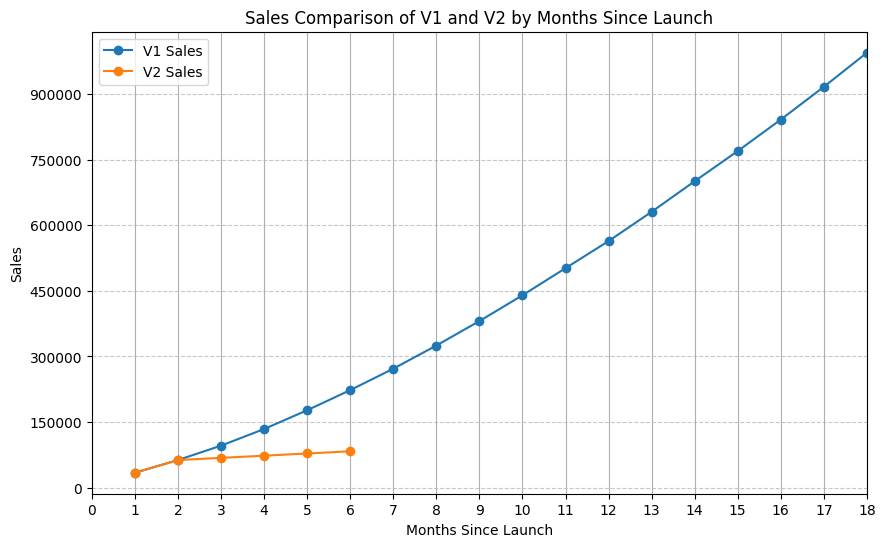

Line chart comparing V1 and V2 sales created successfully.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convert 'sales' column to numeric, coercing errors to NaN
df_combined['sales'] = pd.to_numeric(df_combined['sales'], errors='coerce')

# Drop any rows where sales might have become NaN after conversion
df_combined.dropna(subset=['sales'], inplace=True)

# Create the line plot
plt.figure(figsize=(10, 6))

# Plot V1 sales
df_v1_plot = df_combined[df_combined['product'] == 'V1'].sort_values(by='months_since_launch')
plt.plot(df_v1_plot['months_since_launch'], df_v1_plot['sales'], label='V1 Sales', marker='o')

# Plot V2 sales
df_v2_plot = df_combined[df_combined['product'] == 'V2'].sort_values(by='months_since_launch')
plt.plot(df_v2_plot['months_since_launch'], df_v2_plot['sales'], label='V2 Sales', marker='o')

# Customize x-axis
plt.xlabel('Months Since Launch')
plt.xticks(range(0, 19)) # Show whole numbers from 0 to 18
plt.xlim(0, 18) # Set x-axis limits from 0 to 18

# Customize y-axis
plt.ylabel('Sales')
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True)) # Ensure whole number grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add title and legend
plt.title('Sales Comparison of V1 and V2 by Months Since Launch')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Line chart comparing V1 and V2 sales created successfully.")

### Summary:

### Data Analysis Key Findings

*   The `global_gadgets_fork.monthly_product_sales` table was successfully loaded into a pandas DataFrame, providing sales data for V1 and V2 products, along with their respective 'months\_since\_launch' columns.
*   Data preparation involved restructuring the sales data for V1 and V2 into a combined DataFrame (`df_combined`). This DataFrame contains 24 entries, with sales figures and 'months\_since\_launch' values for both products in a unified format, after removing any missing or zero values.
*   A line chart was successfully generated comparing the sales of V1 and V2. The x-axis accurately represents 'Months Since Launch' from 0 to 18, with grid lines showing every whole number. The y-axis displays sales, with grid lines set to whole numbers for clarity.

### Insights or Next Steps

*   The generated chart provides a clear visual comparison of the sales growth trajectories for V1 and V2 products over their respective launch periods, allowing for direct comparison of their performance from inception.
*   A potential next step could involve calculating and plotting the month-over-month growth rate for each product to provide a more detailed understanding of their sales momentum, and identify any specific months where one product significantly outperformed the other in terms of growth.


### Confirming the drop

As can be seen from the chart, the sales of V2 were initially tracking with the growth of V1 at the same point in its lifecycle but then the growth slowed dramatically.

## **2.** AI to Score Unstructured Data at Scale

### Formulating a plan and using the AI Query Engine functions to analyze unstructured data

We've seen some negative product reviews of the V2 speaker and are wondering how much those reviews might be impacting sales. We'll need to look into other factors such as shopper demographics as well.

But first, to wrangle the review data, we'll need to categorize the reviews in terms of how positive or negative EACH review is toward the key product features that are most often mentioned in reviews for this type of product.

We'll use the **AI.SCORE** function to analyze every V2 product review and to give each review a score from -2 (very negative) to +2 (very positive) with zero being either neutral or not mentioned for each of the four key product features.

The product features are:
* AI Assistant Pro (a new AI assistant added with V2)
* Audio Quality
* Seamless Connectivity
* Smarthome Integration

The following code generates a new table with that information for every V2 product review.

In [11]:
# set the variables for this environment
# You will need to update these variables for YOUR project and location
project_id = "da-opm-sandbox"
location = "US"

In [16]:
# 1. Import the BigQuery client library
from google.cloud import bigquery

# 2. Create a client to interact with the BigQuery API
# It will use the project_id variable you already set.
client = bigquery.Client(project=project_id)

# 3. Define the full SQL query using the f-string
# This part is the same as before.
query = f"""
CREATE OR REPLACE TABLE {project_id}.global_gadgets_fork.reviews_feature_sentiment_score AS SELECT
  review_id,

  -- Score for "AI Assistant Pro"
  AI.SCORE((
    'Score the following review based on its sentiment towards "AI Assistant Pro". '
    'This feature refers to the smart assistant\\'s intelligence, responsiveness, and ability to understand commands (e.g., "the assistant is dumb", "the AI can\\'t understand me"). '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{project_id}.{location}.vertex_ai_connection'
  ) AS ai_assistant_pro_score,

  -- Score for "Audio Quality"
  AI.SCORE((
    'Score the following review based on its sentiment towards "Audio Quality". '
    'This feature refers to how the speaker sounds (e.g., "great bass", "clear sound", "it\\'s loud"). '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{project_id}.{location}.vertex_ai_connection'
  ) AS audio_quality_score,

  -- Score for "Seamless Connectivity"
  AI.SCORE((
    'Score the following review based on its sentiment towards "Seamless Connectivity". '
    'This feature refers to how well the speaker connects to Wi-Fi or Bluetooth (e.g., "connection drops", "setup was easy"). '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{project_id}.{location}.vertex_ai_connection'
  ) AS seamless_connectivity_score,

  -- Score for "Smart Home Integration"
  AI.SCORE((
    'Score the following review based on its sentiment towards "Smart Home Integration". '
    'This feature refers to its ability to control other devices like lights or thermostats. '
    'Use this scoring rubric: +2 (Very Positive), +1 (Positive), 0 (Neutral or Not Mentioned), -1 (Negative), -2 (Very Negative). '
    'Review: ', review_body),
    connection_id => '{project_id}.{location}.vertex_ai_connection'
  ) AS smart_home_integration_score

FROM
  `{project_id}`.global_gadgets_fork.product_reviews
"""

# 4. Execute the query and wait for the job to complete
print("Executing query...")
query_job = client.query(query)
query_job.result()  # Waits for the job to finish.

print(f"Query finished successfully. Job {query_job.job_id} is complete.")

Executing query...
Query finished successfully. Job 08f155af-60e2-4c03-a4f3-5dcf26ffd85b is complete.


## **3.** Gathering all of the data: The bigger picture

Now that we have the review sentiment information, we need to do two more things to prepare for our final analysis. We need to look at which site visitors to the V2 product page did NOT convert to purchases and for them:
* Which negatively reviewed features did they see
* What is all of the demographic and device data that we have

We need to prepare a table for a final analysis so that our model can determine the weight of the different features to predict which feature is most influential in visitors choosing NOT to purchase. We need anctionable insights.

The demographic features we'll look at are gender, age range and the urbanicity of the visitors location. The device information we'll consider will be mobile, desktop, tablet.

The code below will identify which V2 product page visits saw which reviews and will have 1-hot columns for the four features to determine if any of those reviews had a very negative review of any of those features. It will also have 1-hot columns for demographic and device informaiton.

This massively joined table will be used in the final analysis.

In [17]:
# 1. Define the full SQL query using the f-string
query = f"""
CREATE OR REPLACE TABLE `{project_id}`.global_gadgets_fork.FINAL_ANALYSIS AS (
WITH
  -- Unnest the comma-separated list of review IDs for each session
  session_reviews_unnested AS (
    SELECT
      session_id,
      -- Using REPLACE to remove single quotes and TRIM for whitespace
      REPLACE(TRIM(review_id), "'", "") AS review_id
    FROM
      `{project_id}`.global_gadgets_fork.sessions_reviews,
      UNNEST(SPLIT(reviews_seen, ',')) AS review_id
  )
-- Join all tables and perform the final aggregation
SELECT
  s.session_id,
  s.`session_date-time`,
  s.device_type,
  s.converted,
  -- Create a flag (1 or 0) if any review seen had a score of -2 for each feature
  MAX(IF(scores.ai_assistant_pro_score = -2, 1, 0)) AS AI_Assistant_neg_review_seen,
  MAX(IF(scores.audio_quality_score = -2, 1, 0)) AS Audio_Quality_neg_review_seen,
  MAX(IF(scores.seamless_connectivity_score = -2, 1, 0)) AS Seamless_Connectivity_neg_review_seen,
  MAX(IF(scores.smart_home_integration_score = -2, 1, 0)) AS Smart_Home_Integration_neg_review_seen,
  -- One-hot encoded columns from user_info (based on actual distinct values)
  CASE WHEN ui.gender = 'M' THEN 1 ELSE 0 END AS gender_M,
  CASE WHEN ui.gender = 'F' THEN 1 ELSE 0 END AS gender_F,
  CASE WHEN ui.age_range = '31 - 45' THEN 1 ELSE 0 END AS age_range_31_45,
  CASE WHEN ui.age_range = '>60' THEN 1 ELSE 0 END AS age_range_gt60,
  CASE WHEN ui.age_range = '20 - 30' THEN 1 ELSE 0 END AS age_range_20_30,
  CASE WHEN ui.age_range = '46 - 60' THEN 1 ELSE 0 END AS age_range_46_60,
  CASE WHEN ui.age_range = '<20' THEN 1 ELSE 0 END AS age_range_lt20,
  CASE WHEN ui.urbanicity = 'suburban' THEN 1 ELSE 0 END AS urbanicity_suburban,
  CASE WHEN ui.urbanicity = 'rural' THEN 1 ELSE 0 END AS urbanicity_rural,
  CASE WHEN ui.urbanicity = 'urban' THEN 1 ELSE 0 END AS urbanicity_urban,
  -- New one-hot encoded columns for device_type
  CASE WHEN s.device_type = 'desktop' THEN 1 ELSE 0 END AS device_type_desktop,
  CASE WHEN s.device_type = 'mobile' THEN 1 ELSE 0 END AS device_type_mobile,
  CASE WHEN s.device_type = 'tablet' THEN 1 ELSE 0 END AS device_type_tablet
FROM
  `{project_id}`.global_gadgets_fork.sessions AS s
  -- Join sessions with the now-clean unnested reviews
  INNER JOIN session_reviews_unnested AS ur ON s.session_id = ur.session_id
  -- Join with the scores table to get the sentiment for each review
  INNER JOIN `{project_id}`.global_gadgets_fork.reviews_feature_sentiment_score AS scores ON ur.review_id = scores.review_id
  -- Join with session_to_user_map to get user_id
  INNER JOIN `{project_id}`.global_gadgets_fork.session_to_user_map AS stum ON s.session_id = stum.session_id
  -- Join with user_info table
  INNER JOIN `{project_id}`.global_gadgets_fork.user_info AS ui ON stum.user_id = ui.user_id
GROUP BY
  s.session_id,
  s.`session_date-time`,
  s.device_type,
  s.converted,
  -- Include new one-hot encoded columns in GROUP BY
  gender_M,
  gender_F,
  age_range_31_45,
  age_range_gt60,
  age_range_20_30,
  age_range_46_60,
  age_range_lt20,
  urbanicity_suburban,
  urbanicity_rural,
  urbanicity_urban,
  -- New one-hot encoded columns for device_type in GROUP BY
  device_type_desktop,
  device_type_mobile,
  device_type_tablet
)
"""

# 2. Execute the query and wait for the job to complete
print("Executing FINAL_ANALYSIS query...")
query_job = client.query(query)
query_job.result()  # Waits for the job to finish.

print(f"Query finished successfully. Job {query_job.job_id} is complete.")

Executing FINAL_ANALYSIS query...
Query finished successfully. Job 44e366ce-1708-4854-ade3-d591d6e0a833 is complete.


## **4.** Model to predict the feature weight: The data science heavy lifting with the Data Science Agent

Now that we have all of the data in a final table ready for analysis, we'll ask the Data Science Agent to run an XGBOOST model to identify the feature weights and to visualize the weights. The prompt below was used the generate the code and analysis that follows. It is included here for demonstration purposes.

Our hope is that we can identify key factor(s) driving the drop in sales growth so that we can take corrective action.

**The Prompt:**

> This prompt generated the below code. It does not need to be entered again. It is included here for demonstration purposes only.

*Using the FINAL_ANALYSIS table, create an XGBOOST model to determine to what degree any demographic factors or device types or negative review seen is impacting why a shopper decided not to purchase the device. Show a visualization of the feature importance.*

### Task
Create an XGBoost model using the data from `FINAL_ANALYSIS` table to determine the impact of demographic factors, device types, and negative reviews on shopper purchase decisions.

### Data loading

### Subtask:
Load the `FINAL_ANALYSIS` table into a pandas DataFrame.


**Reasoning**:
To load the `FINAL_ANALYSIS` table into a pandas DataFrame, I will import `pandas_gbq`, define the project and table IDs, construct the SQL query, and then use `gbq.read_gbq` to fetch the data. Finally, I will display the head and info of the DataFrame to confirm successful loading.



In [ ]:
import pandas_gbq as gbq

project_id = 'da-opm-sandbox'
table_id = 'global_gadgets_fork.FINAL_ANALYSIS'

query = f"""SELECT * FROM `{project_id}.{table_id}`"""

df_final_analysis = gbq.read_gbq(query, project_id=project_id)

print("Data loaded successfully. Displaying the first 5 rows:")
df_final_analysis.head()
print("\nInfo of the DataFrame:")
df_final_analysis.info()

Downloading: 100%|██████████|
Data loaded successfully. Displaying the first 5 rows:

Info of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype              
---  ------                                  --------------  -----              
 0   session_id                              10884 non-null  object             
 1   session_date-time                       10884 non-null  datetime64[us, UTC]
 2   device_type                             10884 non-null  object             
 3   converted                               10884 non-null  boolean            
 4   AI_Assistant_neg_review_seen            10884 non-null  Int64              
 5   Audio_Quality_neg_review_seen           10884 non-null  Int64              
 6   Seamless_Connectivity_neg_review_seen   10884 non-null  Int64              
 7   Smart_Home_Integration_neg_review_seen  10884 no

### Data preprocessing

### Subtask:
Prepare the data for the XGBoost model, including handling categorical features and splitting into training and testing sets.


**Reasoning**:
To prepare the data for the XGBoost model, I will separate the target and features, drop irrelevant columns, and then split the data into training and testing sets as per the instructions.



In [ ]:
from sklearn.model_selection import train_test_split

# Separate target variable 'converted' from features
X = df_final_analysis.drop('converted', axis=1)
y = df_final_analysis['converted']

# Drop irrelevant columns from features DataFrame
X = X.drop(['session_id', 'session_date-time', 'device_type'], axis=1)

# Split the data into training and testing sets (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared and split into training and testing sets successfully.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data prepared and split into training and testing sets successfully.
Shape of X_train: (8707, 17)
Shape of X_test: (2177, 17)
Shape of y_train: (8707,)
Shape of y_test: (2177,)


### Model training

### Subtask:
Train an XGBoost classification model.


**Reasoning**:
To train the XGBoost classification model, I will import `XGBClassifier`, instantiate it with the specified parameters to avoid warnings, and then fit the model to the training data.



In [ ]:
import xgboost as xgb

# Instantiate XGBClassifier
# Setting use_label_encoder=False and eval_metric='logloss' to suppress warnings
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
model.fit(X_train, y_train)

print("XGBoost classification model trained successfully.")

XGBoost classification model trained successfully.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:13:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Model evaluation

### Subtask:
Evaluate the trained model's performance.


**Reasoning**:
To evaluate the model, I will import the necessary metrics from `sklearn.metrics`, make predictions on the test set, and then compute and display the accuracy, precision, recall, and F1-score.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Model Evaluation Metrics:\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Model Evaluation Metrics:

Accuracy: 0.8222
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Feature importance analysis

### Subtask:
Determine the importance of each feature in predicting shopper purchase decisions.


**Reasoning**:
To determine feature importance, I will access the trained model's `feature_importances_` attribute, create a pandas Series with feature names from `X_train`, sort it, and then print the results.



In [ ]:
import pandas as pd

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a pandas Series with feature names
feature_names = X_train.columns
importance_df = pd.Series(feature_importances, index=feature_names)

# Sort feature importances in descending order
sorted_importance = importance_df.sort_values(ascending=False)

print("Feature Importances (sorted descending):")
print(sorted_importance)

Feature Importances (sorted descending):
AI_Assistant_neg_review_seen              0.739801
urbanicity_rural                          0.078660
age_range_46_60                           0.046397
device_type_mobile                        0.043561
device_type_tablet                        0.016583
gender_M                                  0.014598
age_range_lt20                            0.012596
age_range_20_30                           0.010700
device_type_desktop                       0.010470
age_range_31_45                           0.009705
urbanicity_suburban                       0.006230
age_range_gt60                            0.006018
urbanicity_urban                          0.004682
gender_F                                  0.000000
Audio_Quality_neg_review_seen             0.000000
Seamless_Connectivity_neg_review_seen     0.000000
Smart_Home_Integration_neg_review_seen    0.000000
dtype: float32


### Summary:

### Q&A

**To what degree are demographic factors, device types, or negative reviews impacting why a shopper decided not to purchase the device?**

The XGBoost model indicates that the most significant factor impacting a shopper's decision not to purchase (or conversion) is `AI_Assistant_neg_review_seen`, with an importance score of approximately 0.74. This suggests that whether a shopper has viewed negative reviews related to AI Assistant features is highly influential. Other impactful factors, though to a much lesser degree, include `urbanicity_rural` (0.079), `age_range_46_60` (0.046), and `device_type_mobile` (0.044). Several demographic factors (like gender_F) and other negative review categories (Audio Quality, Seamless Connectivity, Smart Home Integration) showed zero importance in this model.

### Data Analysis Key Findings

*   The `FINAL_ANALYSIS` table, containing 10884 entries and 21 columns, was successfully loaded into a pandas DataFrame.
*   The data was successfully preprocessed, separating the target variable 'converted' from 17 features, and then split into training (8707 samples) and testing (2177 samples) sets.
*   An XGBoost classification model was successfully trained on the prepared data.
*   The trained model achieved an accuracy of 0.8222. However, the precision, recall, and F1-score for the positive class (converted) were 0.0000. This indicates that the model did not predict any positive conversions in the test set, likely due to a significant class imbalance in the target variable.
*   Feature importance analysis revealed that `AI_Assistant_neg_review_seen` is by far the most influential factor, contributing to approximately 74% of the feature importance.
*   Other features with notable, but significantly lower, importance include `urbanicity_rural` (0.079), `age_range_46_60` (0.046), and `device_type_mobile` (0.044).
*   Several features, including `gender_F`, `Audio_Quality_neg_review_seen`, `Seamless_Connectivity_neg_review_seen`, and `Smart_Home_Integration_neg_review_seen`, showed no importance (0.0000) in this model.

### Insights or Next Steps

*   The dominance of `AI_Assistant_neg_review_seen` as a predictor highlights a critical area for improving conversion rates. Businesses should investigate the content of these negative reviews and consider strategies to mitigate their impact, such as improving AI Assistant features or proactively addressing common complaints.
*   The model's inability to predict any positive conversions (Precision, Recall, F1-Score of 0.0000) strongly suggests a class imbalance issue. Future steps should involve addressing this imbalance using techniques like oversampling (SMOTE), undersampling, or adjusting class weights in the XGBoost model to improve its ability to identify and predict conversions.


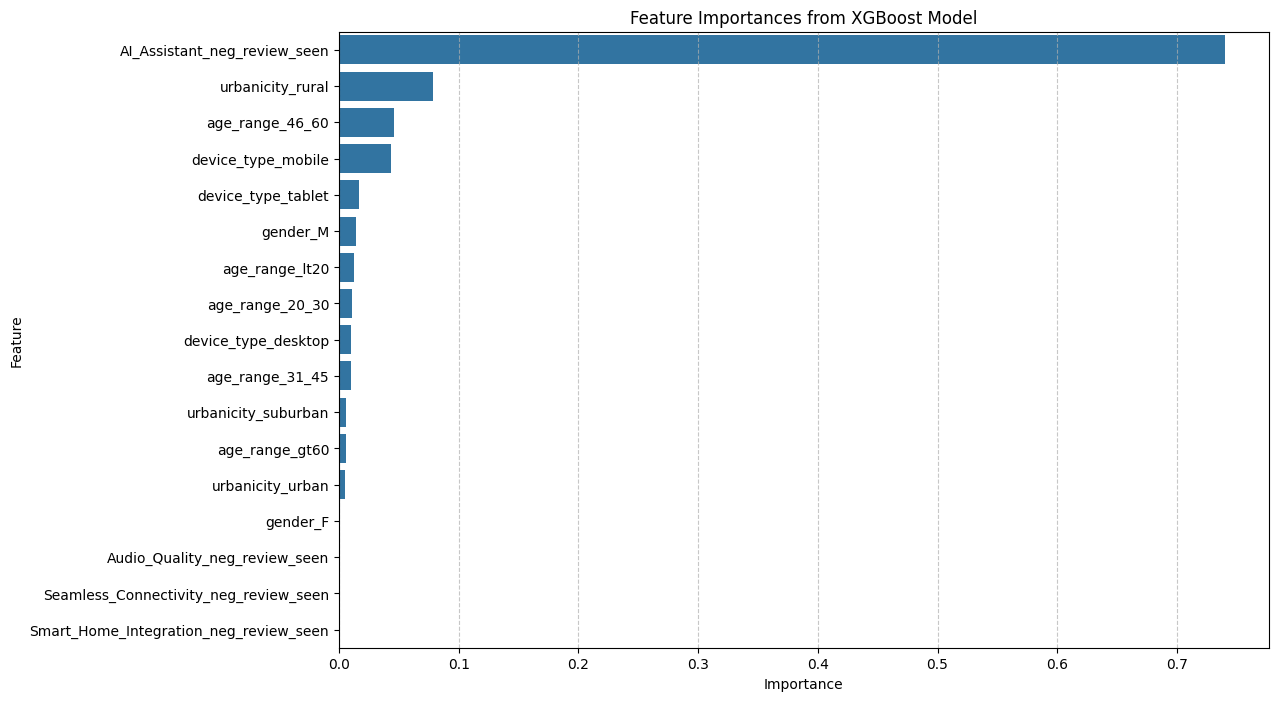

Feature importance visualization created successfully.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot of feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importance.values, y=sorted_importance.index)
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Feature importance visualization created successfully.")

## **5.** Closing: AI scoring at scale and agentic assist are force multipliers

This visualization provides clear confirmation that the product reviews are most responsible for the decline in sales growth. In particular, it is the AI Assistant feature that is being poorly reviewed and when shoppers see those negative reviews they are choosing not to purchase.

This gives us immediate actionable insight and means that our engineering team should be laser focused on addressing the complaints, bugs, issues with the AI Assistant Pro.

The Data Science Agent provides **a powerful multiplier effect for our data scientists,** allowing them to rapidly build, train, and deploy models, delivering critical, actionable intelligence at an unprecedented pace.

As you can see from this notebook, what at first seemed like a difficult question that would have required a team and several days, was quickly broken down and identified within minutes using Google AI Query Engine and Data Science Agent.

